# Data Augmentation

El proceso de Data Augmentation consiste en realizar diversas transformaciones sobre los datos de entrada con el objetivo de aportar variabilidad e incrementar el tamaño de mi conjunto de datos, partiendo de los datos ya existentes y etiquetados. Dichas transformaciones puede ser, como vimos en teoria, de distintos tipos, sin embargo, es necesario tener en cuenta solo utilizar las que sean coherentes con el problema puntual sobre el que estamos trabajando.

Para este ejercicio vamos a trabajar con un dataset de imágenes de perros y gatos, el cual contiene 4000 imagenes a color, 2000 de perros y 2000 de gatos. Dichas imágenes ya se encuentran divididas en 3 carpetas correspondientes a entrenamiento, validación y testeo con 2000, 1000 y 1000 imágenes en cada una, respectivamente.

In [18]:
import os, random, time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch, torchvision, torchmetrics, torchsummary
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader

## Visualización de los datos

A partir de observar las distintas imágenes, podemos notar que no todas conservan las mismas dimensiones, por lo que será necesario realizar un redimensionamiento de forma tal que queden uniformes para un posible entrenamiento con capas convolucionales.

In [19]:
ROOT_PATH = os.getcwd()
TRAIN_PATH = ROOT_PATH + "/dataset/dog_cat/train/"
TEST_PATH = ROOT_PATH + "/dataset/dog_cat/test/"
CAT_TRAIN_PATH = ROOT_PATH + "/dataset/dog_cat/train/cats/"
DOG_TRAIN_PATH = ROOT_PATH + "/dataset/dog_cat/train/dogs/"
CAT_TEST_PATH = ROOT_PATH + "/dataset/dog_cat/test/cats/"
DOG_TEST_PATH = ROOT_PATH + "/dataset/dog_cat/test/dogs/"

In [20]:
cat_train_files = os.listdir(CAT_TRAIN_PATH)
dog_train_files = os.listdir(DOG_TRAIN_PATH)
cat_test_files = os.listdir(CAT_TEST_PATH)
dog_test_files = os.listdir(DOG_TEST_PATH)

## Utilizar los datos

Para consumir los datos con nuestro modelo vamos a utilizar objetos de la clase DataLoader. Tambien, para poder cargar imágenes propias utilizamos la clase [`ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html?highlight=imagefolder#torchvision.datasets.ImageFolder), a la cual le pasamos el directorio donde se encuentran las imágenes a partir del cual infiere las clases dentro del dataset. Para mas información respecto a este punto ver [aquí](https://pytorch.org/vision/stable/generated/torchvision.datasets.DatasetFolder.html#torchvision.datasets.DatasetFolder).

In [21]:
num_classes = 2
class_names = ['cat', 'dog']
width, height = 150, 150

In [22]:
class ConvolutionalBlock(nn.Module):
    def __init__(
            self,
            in_channels: int=1,
            out_channels: int=3,
            kernel_size: int=3,
            stride: int=1,
            padding: int=1,
            padding_mode: str='zeros',
            activation=nn.ReLU(),
            pool_kernel_size: int=3,
            pool_stride: int=1,
            pool_padding: int=1
    ):
        super(ConvolutionalBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.padding_mode = padding_mode
        self.activation = activation
        self.pool_kernel_size = pool_kernel_size
        self.pool_stride = pool_stride
        self.pool_padding = pool_padding

        # Check parameters consistency
        if kernel_size % 2 == 0:
            assert kernel_size == stride, f"Conv: Stride {stride} must be equal to  even kernel size {kernel_size}."
        else:
            assert ((kernel_size-1) / 2 == padding) & stride == 1, f"Conv: Invalid padding {padding} for the given kernel size {kernel_size}"
        if pool_kernel_size % 2 == 0:
            assert pool_kernel_size == pool_stride, f"Pooling: Stride {pool_stride} must be equal to even kernel size {pool_kernel_size}."
        else:
            assert ((pool_kernel_size-1) / 2 == pool_padding) & pool_stride == 1, f"Pooling: Invalid padding {pool_padding} for the given kernel size {pool_kernel_size}"

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, padding_mode=padding_mode),
            activation,
            nn.MaxPool2d(pool_kernel_size, pool_stride, pool_padding)
        )

    def forward(self, x):
        return self.conv_block(x)

    def getConvOutputShape(self, in_shape):
        return (self.out_channels,
                (in_shape[1] - self.kernel_size + 2*self.padding) // self.stride + 1,
                (in_shape[2] - self.kernel_size + 2*self.padding) // self.stride + 1)

    def getPoolOutputShape(self, in_shape):
        return (self.out_channels,
                (in_shape[1] - self.pool_kernel_size + 2*self.pool_padding) // self.pool_stride + 1,
                (in_shape[2] - self.pool_kernel_size + 2*self.pool_padding) // self.pool_stride + 1)

    def getOutputShape(self, in_shape):
        conv_shape = self.getConvOutputShape(in_shape)
        pool_shape = self.getPoolOutputShape(conv_shape)
        return pool_shape

In [23]:
class CNN(nn.Module):

    def __init__(
            self,
            conv_blocks: list,
            image_shape: tuple=(1, 28, 28),
            n_classes: int=10,
            out_neurons: int=64,
            activation=nn.ReLU(),
            criterion=nn.CrossEntropyLoss(),
            dropout_rate: float=0.5,
            init_type: str='xavier',
            device: str='cpu'
    ):
        super(CNN, self).__init__()
        for conv_block in conv_blocks:
            image_shape = conv_block.getOutputShape(image_shape)
        self.out_shape = image_shape
        self.in_neurons = self.out_shape[0] * self.out_shape[1] * self.out_shape[2]
        self.out_neurons = out_neurons
        self.n_classes = n_classes
        self.activation = activation
        self.criterion = criterion
        self.dropout_rate = dropout_rate
        self.init_type = init_type
        self.device = device

        # Define layers
        self.conv_blocks = nn.ModuleList(conv_blocks)
        self.fully_connected = nn.Sequential(
                nn.Linear(self.in_neurons, out_neurons),
                activation,
                nn.Dropout(dropout_rate),
                nn.Linear(out_neurons, n_classes)
        )

        # Initialize the parameters.
        self.initialize_weights(init_type)

        # Define the metrics.
        self.metrics = {
            'epochs': [], 
            'loss': {'train': [], 'eval': []}, 
            'accuracy': {'train': [], 'eval': []}, 
            'time': 0.0
        }

    def initialize_weights(self, init_type):
        for layer in self.fully_connected:
            if isinstance(layer, nn.Linear):
                if init_type == 'xavier':
                    nn.init.xavier_uniform_(layer.weight)
                elif init_type == 'he':
                    nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                else:
                    nn.init.normal_(layer.weight, mean=0, std=0.01)
                if layer.bias is not None:
                    nn.init.uniform_(layer.bias, a=0, b=1)

    def forward(self, x):
        for block in self.conv_blocks:
            x = block(x)
        x = x.view(-1, self.in_neurons)
        return self.fully_connected(x)
    
    def trainBatch(self, inputs_batch, targets_batch, optimizer):
        inputs_batch = inputs_batch.to(self.device)             # push inputs to GPU
        targets_batch = targets_batch.to(self.device)           # push labels to GPU
        predictions_batch = self.forward(inputs_batch)          # forward pass
        loss = self.criterion(predictions_batch, targets_batch) # compute the training loss
        optimizer.zero_grad()                                   # zero the gradients
        loss.backward()                                         # backward pass
        optimizer.step()                                        # update the parameters (weights and biases)
        return loss.item()

    def predict(self, inputs):
        predictions = self.forward(inputs)
        _, predictions = torch.max(predictions.data, 1)
        return predictions

    def computeLoss(self, dataloader):
        loss = 0.0
        samples = 0
        self.eval() # set the model to evaluation mode
        for inputs_batch, targets_batch in dataloader:
            with torch.no_grad():
                inputs_batch = inputs_batch.to(self.device)                             # push inputs to GPU
                targets_batch = targets_batch.to(self.device)                           # push labels to GPU
                predictions_batch = self.forward(inputs_batch)                          # forward pass
                batch_loss = self.criterion(predictions_batch, targets_batch).item()    # compute the loss
                loss += batch_loss * inputs_batch.size(0)                               # accumulate the weighted loss
                samples += inputs_batch.size(0)                                         # accumulate the number of samples
        return loss / samples

    def computeAccuracy(self, dataloader):
        samples = 0
        true_predictions = 0
        self.eval() # set the model to evaluation mode
        for inputs_batch, targets_batch in dataloader:
            with torch.no_grad():
                inputs_batch = inputs_batch.to(self.device)         # push inputs to GPU
                targets_batch = targets_batch.to(self.device)       # push labels to GPU
                predictions_batch = self.forward(inputs_batch)      # forward pass
                true_predictions += torch.sum(torch.argmax(predictions_batch, dim=1) == targets_batch).item()
                samples += targets_batch.shape[0]
        return true_predictions / samples
    
    def fit(self, train_dataloader, optimizer=optim.Adam, epochs=30, lr=1e-4, 
        regularization=0.0, eval_dataloader=None, verbose=True, epch_print=1, 
        tolerance=1e-3, patience=5):

        # Set the starting epoch
        last_epoch = self.metrics['epochs'][-1] if self.metrics['epochs'] else 0
        starting_epoch = last_epoch + 1
    
        # Set the optimizer
        optimizer = optimizer(self.parameters(), lr=lr, weight_decay=regularization)

        # Variables for early stopping
        error_loss, error_accuracy = 1, 1
        old_loss, old_accuracy = None, None
        epochs_since_improvement = 0

        # Start the training
        start_time = time.time()
        for i in range(epochs):
            self.train()
            for train_batch in train_dataloader:
                self.trainBatch(train_batch[0], train_batch[1], optimizer)

            # Evaluate the model
            self.eval()
            train_loss = self.computeLoss(train_dataloader)
            train_acc = self.computeAccuracy(train_dataloader)
            self.metrics['epochs'].append(starting_epoch + i)
            self.metrics['loss']['train'].append(train_loss)
            self.metrics['accuracy']['train'].append(train_acc)
            if eval_dataloader:
                eval_loss = self.computeLoss(eval_dataloader)
                eval_acc = self.computeAccuracy(eval_dataloader)
                self.metrics['loss']['eval'].append(eval_loss)
                self.metrics['accuracy']['eval'].append(eval_acc)

                # Check early stopping conditions on eval set
                if i == 0:
                    old_loss, old_accuracy = eval_loss, eval_acc
                else:
                    error_loss = abs(eval_loss - old_loss) / old_loss
                    error_accuracy = abs(eval_acc - old_accuracy) / old_accuracy
                    old_loss, old_accuracy = eval_loss, eval_acc
            else:
                # Check early stopping conditions on train set
                if i == 0:
                    old_loss, old_accuracy = train_loss, train_acc
                else:
                    error_loss = abs(train_loss - old_loss) / old_loss
                    error_accuracy = abs(train_acc - old_accuracy) / old_accuracy
                    old_loss, old_accuracy = train_loss, train_acc
            
            if (error_loss <= tolerance) and (error_accuracy <= tolerance):
                epochs_since_improvement += 1
            else:
                epochs_since_improvement = 0
            
            # Print the progress
            if verbose and (i + 1) % epch_print == 0:
                eval_loss = eval_loss if eval_dataloader else 'N/A'
                text = f"Epoch {starting_epoch + i}/{starting_epoch + epochs}: "
                text += f"Loss ({train_loss:.4g}, {eval_loss:.4g}) \t "
                text += f"Accuracy ({100*train_acc:.2f}%, {100*eval_acc:.2f}%)"
                print(text)

            # Early stopping check
            if epochs_since_improvement >= patience:
                print(f"Early stopping triggered after {i + 1} epochs.")
                break

        self.metrics['time'] += time.time() - start_time

    def size(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def save(self, path: str="cnn_model_params.pth"):
        torch.save(self.state_dict(), path)

    def load(self, path: str="cnn_model_params.pth"):
        self.load_state_dict(torch.load(path))
        self.to(self.device)

In [24]:
parameters = {
        'conv_layers': [
            {
                'in_channels': 3,
                'out_channels': 16,
                'kernel_size': 3,
                'stride': 1,
                'padding': 1,
                'padding_mode': 'zeros',
                'pool_kernel_size': 2,
                'pool_stride': 2,
                'pool_padding': 0
            },
            {
                'in_channels': 16,
                'out_channels': 32,
                'kernel_size': 3,
                'stride': 1,
                'padding': 1,
                'padding_mode': 'zeros',
                'pool_kernel_size': 2,
                'pool_stride': 2,
                'pool_padding': 0
            },
            {
                'in_channels': 32,
                'out_channels': 64,
                'kernel_size': 3,
                'stride': 1,
                'padding': 1,
                'padding_mode': 'zeros',
                'pool_kernel_size': 2,
                'pool_stride': 2,
                'pool_padding': 0
            },
            {
                'in_channels': 64,
                'out_channels': 128,
                'kernel_size': 3,
                'stride': 1,
                'padding': 1,
                'padding_mode': 'zeros',
                'pool_kernel_size': 2,
                'pool_stride': 2,
                'pool_padding': 0
            }
        ],
        'full_layers': [512],
        'n_classes': 2,
        'dropout_rate': 0.2,
        'activation': nn.ReLU(),
        'criterion': nn.CrossEntropyLoss(),
        'init_type': 'xavier',
        'device': 'cpu'
    }

In [25]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(width, height)),
    torchvision.transforms.ToTensor()
    ])

train_set = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform=transforms)
valid_set = torchvision.datasets.ImageFolder(root=TEST_PATH, transform=transforms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)

In [26]:
# Build the model
conv_blocks = []
for conv_layer in parameters['conv_layers']:
    conv_block = ConvolutionalBlock(**conv_layer)
    conv_blocks.append(conv_block)
model = CNN(conv_blocks=conv_blocks, 
            image_shape=(3, width, height),
            n_classes=parameters['n_classes'],
            out_neurons=parameters['full_layers'][0],
            activation=parameters['activation'], 
            criterion=parameters['criterion'], 
            dropout_rate=parameters['dropout_rate'],
            init_type=parameters['init_type'],
            device=parameters['device'])
model = model.to(model.device)

In [27]:
# Define fit parameters.
optimizer = optim.Adam
epochs = 30
lr = 1e-4
verbose = True
epch_print = 5
tolerance = 1e-3
patience = 10

In [28]:
model.fit(train_loader, optimizer=optimizer, epochs=epochs, lr=lr, 
          eval_dataloader=valid_loader, verbose=verbose, epch_print=epch_print, 
          tolerance=tolerance, patience=patience)
model.save("cat_dog.pth")

Epoch 5/31: Loss (0.5593, 0.6129) 	 Accuracy (71.90%, 67.00%)
Epoch 10/31: Loss (0.471, 0.5878) 	 Accuracy (78.40%, 69.60%)
Epoch 15/31: Loss (0.4078, 0.5892) 	 Accuracy (81.95%, 71.80%)
Epoch 20/31: Loss (0.3034, 0.5862) 	 Accuracy (88.45%, 72.10%)
Epoch 25/31: Loss (0.2091, 0.6085) 	 Accuracy (92.80%, 74.30%)
Epoch 30/31: Loss (0.1569, 0.7134) 	 Accuracy (94.15%, 73.50%)


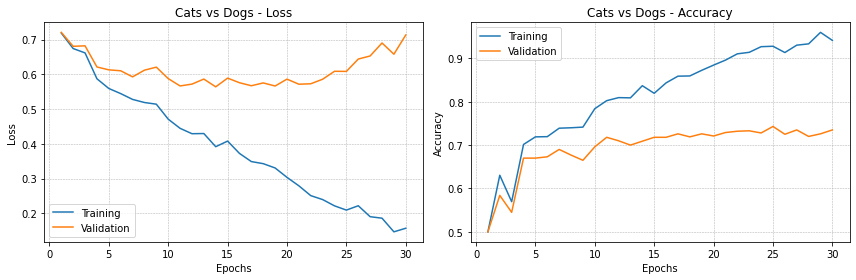

In [36]:
# Plot the results
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot loss
axs[0].plot(model.metrics['epochs'], model.metrics['loss']['train'], label=f"Training")
axs[0].plot(model.metrics['epochs'], model.metrics['loss']['eval'], label=f"Validation")
axs[0].set_title("Cats vs Dogs - Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend(loc='best')
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot accuracy
axs[1].plot(model.metrics['epochs'], model.metrics['accuracy']['train'], label=f"Training")
axs[1].plot(model.metrics['epochs'], model.metrics['accuracy']['eval'], label=f"Validation")
axs[1].set_title("Cats vs Dogs - Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend(loc='best')
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig("cat_dog_results.png", dpi=300, facecolor='w', edgecolor='w')
plt.show()

Su puede observar una clara tendencia al sobreentrenamiento del modelo, el cual es debido a, entre otras cosas, la poca cantidad de datos de entrenamiento utilizados.

---
## Aplicar Data Augmentation

Para aplicar Data Augmentation sobre los datos vamos a utilizar la misma composición de transformaciones que ya veniamos utilizando. Allí podemos agregar una serie de funciones listadas [`aquí`](https://pytorch.org/vision/stable/transforms.html). Para ver ejemplos de dichas transformaciones ver [este](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) link.

Ademas de las transformaciones implementadas dentro del modulo `torchvision` de Pytorch, podemos optar por utilizar librerias externas para dicho proposito e integrar sus transformaciones en el pipeline de entrenamiento de Pytorch.

In [30]:
aug_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(width, height)),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.RandomResizedCrop(size=(width, height), scale=(0.5, 1.0)),
    torchvision.transforms.ColorJitter(saturation=0.1, hue=0.1),
    torchvision.transforms.ToTensor()
])

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(width, height)),
    torchvision.transforms.ToTensor()
])

aug_train_set = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform=aug_transforms)
aug_valid_set = torchvision.datasets.ImageFolder(root=TEST_PATH, transform=transforms)

aug_train_loader = torch.utils.data.DataLoader(aug_train_set, batch_size=32, shuffle=True)
aug_valid_loader = torch.utils.data.DataLoader(aug_valid_set, batch_size=32, shuffle=True)

Si ahora, repito el proceso de entrenamiento, utilizando la misma arquitectura de red neuronal del caso anterior, pero pasandole datos sobre los que realizo las perturbaciones antes definidas, mi entrenamiento deberia ser más estable aunque un poco mas lento.

In [31]:
# Build the model
conv_blocks = []
for conv_layer in parameters['conv_layers']:
    conv_block = ConvolutionalBlock(**conv_layer)
    conv_blocks.append(conv_block)
model_aug = CNN(conv_blocks=conv_blocks, 
                image_shape=(3, width, height),
                n_classes=parameters['n_classes'],
                out_neurons=parameters['full_layers'][0],
                activation=parameters['activation'], 
                criterion=parameters['criterion'], 
                dropout_rate=parameters['dropout_rate'],
                init_type=parameters['init_type'],
                device=parameters['device'])
model_aug = model_aug.to(model_aug.device)

In [32]:
model_aug.fit(aug_train_loader, optimizer=optimizer, epochs=epochs, lr=lr, 
              eval_dataloader=aug_valid_loader, verbose=verbose, epch_print=epch_print, 
              tolerance=tolerance, patience=patience)
model_aug.save("cat_dog_aug.pth")

Epoch 5/31: Loss (0.6256, 0.6685) 	 Accuracy (65.00%, 60.10%)
Epoch 10/31: Loss (0.5579, 0.6039) 	 Accuracy (72.10%, 68.20%)
Epoch 15/31: Loss (0.5382, 0.5789) 	 Accuracy (72.30%, 70.20%)
Epoch 20/31: Loss (0.5189, 0.5642) 	 Accuracy (74.00%, 71.10%)
Epoch 25/31: Loss (0.4961, 0.5543) 	 Accuracy (74.45%, 71.50%)
Epoch 30/31: Loss (0.4662, 0.5427) 	 Accuracy (78.35%, 72.10%)


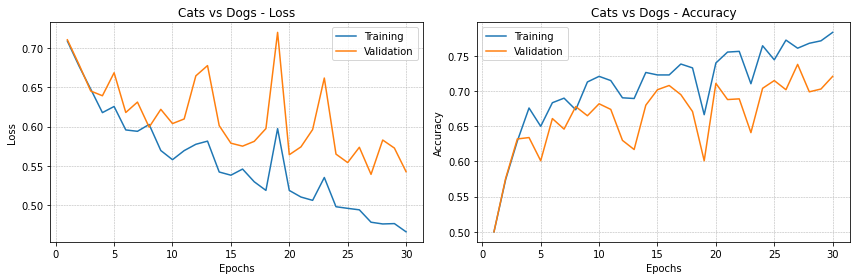

In [35]:
# Plot the results
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot loss
axs[0].plot(model_aug.metrics['epochs'], model_aug.metrics['loss']['train'], label=f"Training")
axs[0].plot(model_aug.metrics['epochs'], model_aug.metrics['loss']['eval'], label=f"Validation")
axs[0].set_title("Cats vs Dogs - Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend(loc='best')
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot accuracy
axs[1].plot(model_aug.metrics['epochs'], model_aug.metrics['accuracy']['train'], label=f"Training")
axs[1].plot(model_aug.metrics['epochs'], model_aug.metrics['accuracy']['eval'], label=f"Validation")
axs[1].set_title("Cats vs Dogs - Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend(loc='best')
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig("cat_dog_aug_results.png", dpi=300, facecolor='w', edgecolor='w')
plt.show()

---
## TensorBoard

Otra forma de visualizar los resultados del entrenamiento de nuestra red es mediante la herramienta TensorBoard, la cual forma parte del framework de Tensorflow. Esta herramienta nos permite ver graficas interactivas de la evolución de las distintas metricas a lo largo de las epocas o las iteraciones de entrenamiento, así como también un grafo de las conexiones que componen nuestro modelo, entre otras cosas.